Name: Renny Wang Itick

Kaggle: https://www.kaggle.com/code/rennywang96/house-prices-ex2

Intro:

In this excise were tasked with predicting house prices with a reggresion model, based on a given dataframe.

We'll get the data, analize it, clean and organize it, then instead of using a simple split to train and validation groups we will use cross validation for estimation befor the test, we'll use normalization and freature selection methonds as well.

In [ ]:
# basic importing
import numpy as np
import pandas as pd 
import os

**Get the data**:

In [ ]:
# for colab run
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/CS - Courses/ML/EX2/train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#  default kaggle imports and input
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

In [ ]:
# see the given df
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [ ]:
# show df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

let's create a report of the data by using sweetviz and get a deeper understanding of our data:

In [ ]:
# import sweetviz and use it to analyze the data
!pip install sweetviz
import sweetviz as sw

df_analysis = sw.analyze(df)
df_analysis.show_notebook(layout='vertical')

Output hidden; open in https://colab.research.google.com to view.

from the report we can conclude that there are some missing values in some feature, a small amout of that can be fixed reliabliy with random categorical value or the median value, on the other hand a great amout of missing value will make the feature absolutist




**def functions**:

In [ ]:
# count empty values in each column
def count_empty_values_in_cols(df: pd.DataFrame):
  print('empty values')
  print('------------\n')
  empty_columns = []
  for col in df.columns:
    empty = df[col].isna().sum()
    if empty != 0:
      empty_columns.append(col)
      print(f"{col}: {empty}")   
  return empty_columns


# fill empty values with medians 
def fill_cols_median_val(df, column_names):
  for column_name in column_names:
    df_not_null = df[~df[column_name].isnull()]
    df[column_name].fillna(df_not_null[column_name].median(), inplace=True) 

# fill empty values with mode
def fill_cols_mode_val(df, column_names):
  for column_name in column_names:
    df[column_name].fillna(df[column_name].mode()[0], inplace=True) 
    
# get names of columns with objects and numerical separately 
def split_types(df):
    objects_names = []
    numerical_names = []
    for feature in df:
        if  df[feature].dtype== 'object':
            objects_names.append(feature)
        else:
            numerical_names.append(feature) 
    return objects_names, numerical_names   
    

# set encoder (seen in class to have good preformens), although this will make the df messy with the spliting of the features
from sklearn import preprocessing
encoder = preprocessing.OneHotEncoder(drop="first", sparse=False)

# dummy encoding data
def encode_categorical(data, objects_names):
    org_data_without_objects = data.drop(df[objects_names], axis=1, inplace=False) 
    for name in objects_names:
        dummies = pd.get_dummies(data[name], prefix= name, columns=[name], drop_first=False)     
        org_data_without_objects = pd.concat([org_data_without_objects, dummies], axis=1)
    return org_data_without_objects


In [ ]:
# check for empty cols in df
print("rows:" + str(len(df)))
df_empty_columns = count_empty_values_in_cols(df)

rows:1460
empty values
------------

LotFrontage: 259
Alley: 1369
MasVnrType: 8
MasVnrArea: 8
BsmtQual: 37
BsmtCond: 37
BsmtExposure: 38
BsmtFinType1: 37
BsmtFinType2: 38
Electrical: 1
FireplaceQu: 690
GarageType: 81
GarageYrBlt: 81
GarageFinish: 81
GarageQual: 81
GarageCond: 81
PoolQC: 1453
Fence: 1179
MiscFeature: 1406


removing  irrelevant features:

id - shouldn't have any effect

any feature that is mostly empty shall be removed as well

In [ ]:
# drop ID and any features with a definitive size of missing values 
columns_to_drop = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
df.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
# split type of data to fill in the right way
objects_names, numerical_names = split_types(df)

# fill empty values in test dataframe
fill_cols_median_val(df, numerical_names)
fill_cols_mode_val(df, objects_names)

# check if there is no more missing values in test
df_empty_columns = count_empty_values_in_cols(df)

empty values
------------



now all missing values are filled now let's figure out what features are irelevant

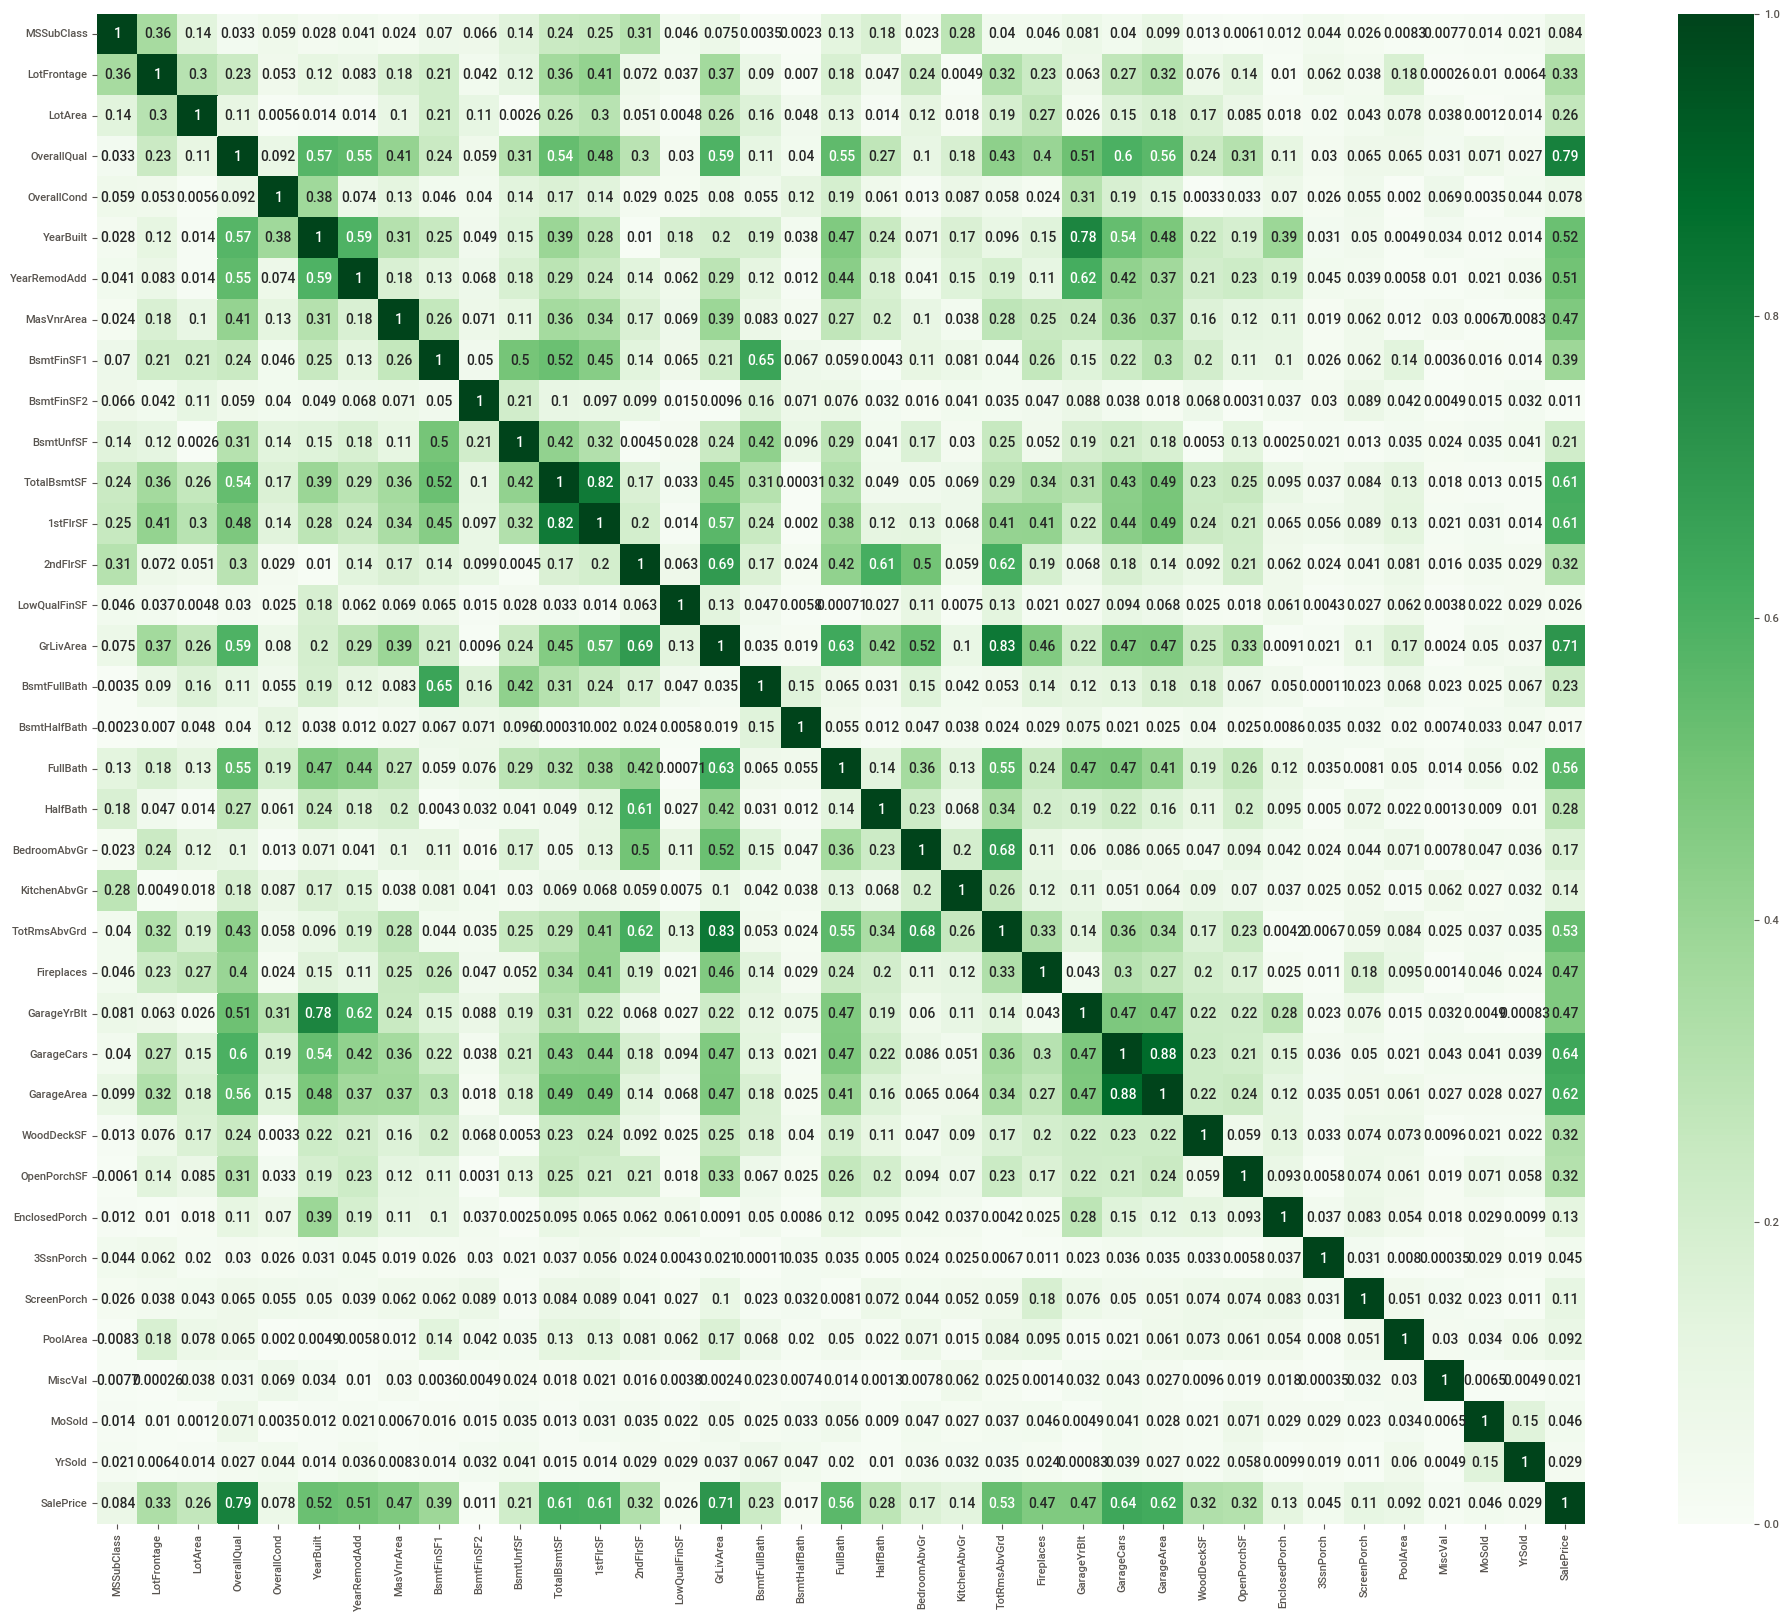

In [ ]:
# craete corelation matrix for df
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24,20))
cor = abs(df.corr())
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens, vmin=0, vmax=1)
plt.show()

from the matrix we can see which feature has low corelation with the SalePrice, therefore we shall remove them, with a general rule of relevancy above 0.1 corelation score.

In [ ]:
# find drop low correlations features
low_correlation_features=cor[cor['SalePrice'] < 0.1].index
df.drop(low_correlation_features, axis=1, inplace=True)

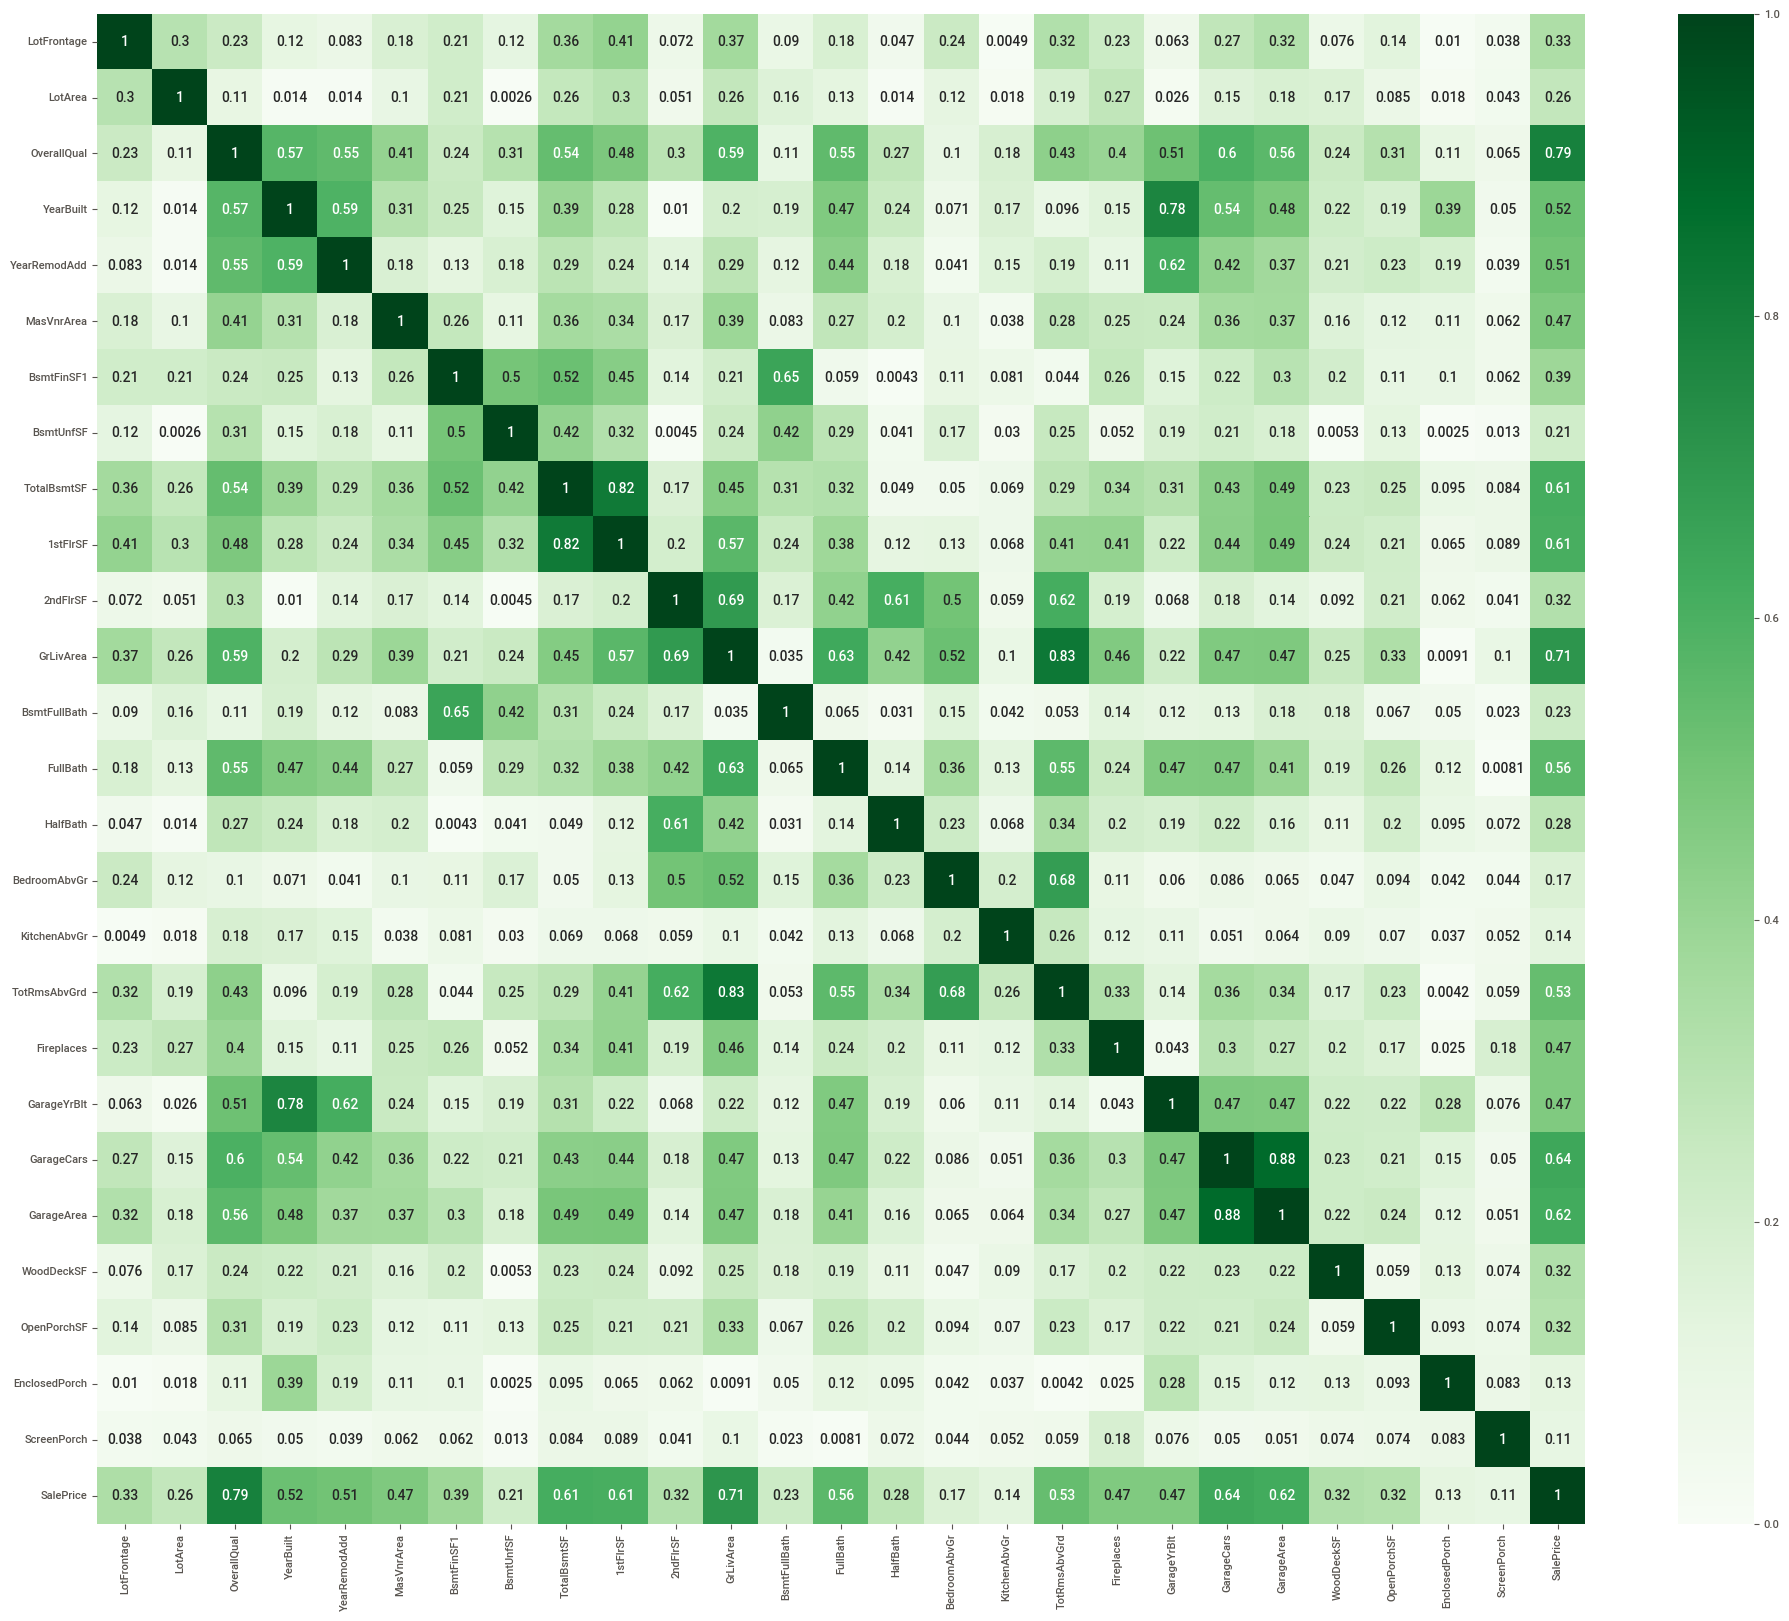

In [ ]:
plt.figure(figsize=(24,20))
cor = abs(df.corr())
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens, vmin=0, vmax=1)
plt.show()

encode the categorical features:

In [ ]:
df_encoded = encode_categorical(df, objects_names)
df_encoded.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,2003,2003,196.0,706,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,1976,1976,0.0,978,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,2001,2002,162.0,486,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,1915,1970,0.0,216,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,2000,2000,350.0,655,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


The dummy encoding can also create some unrelevent feature, so we'll remove them

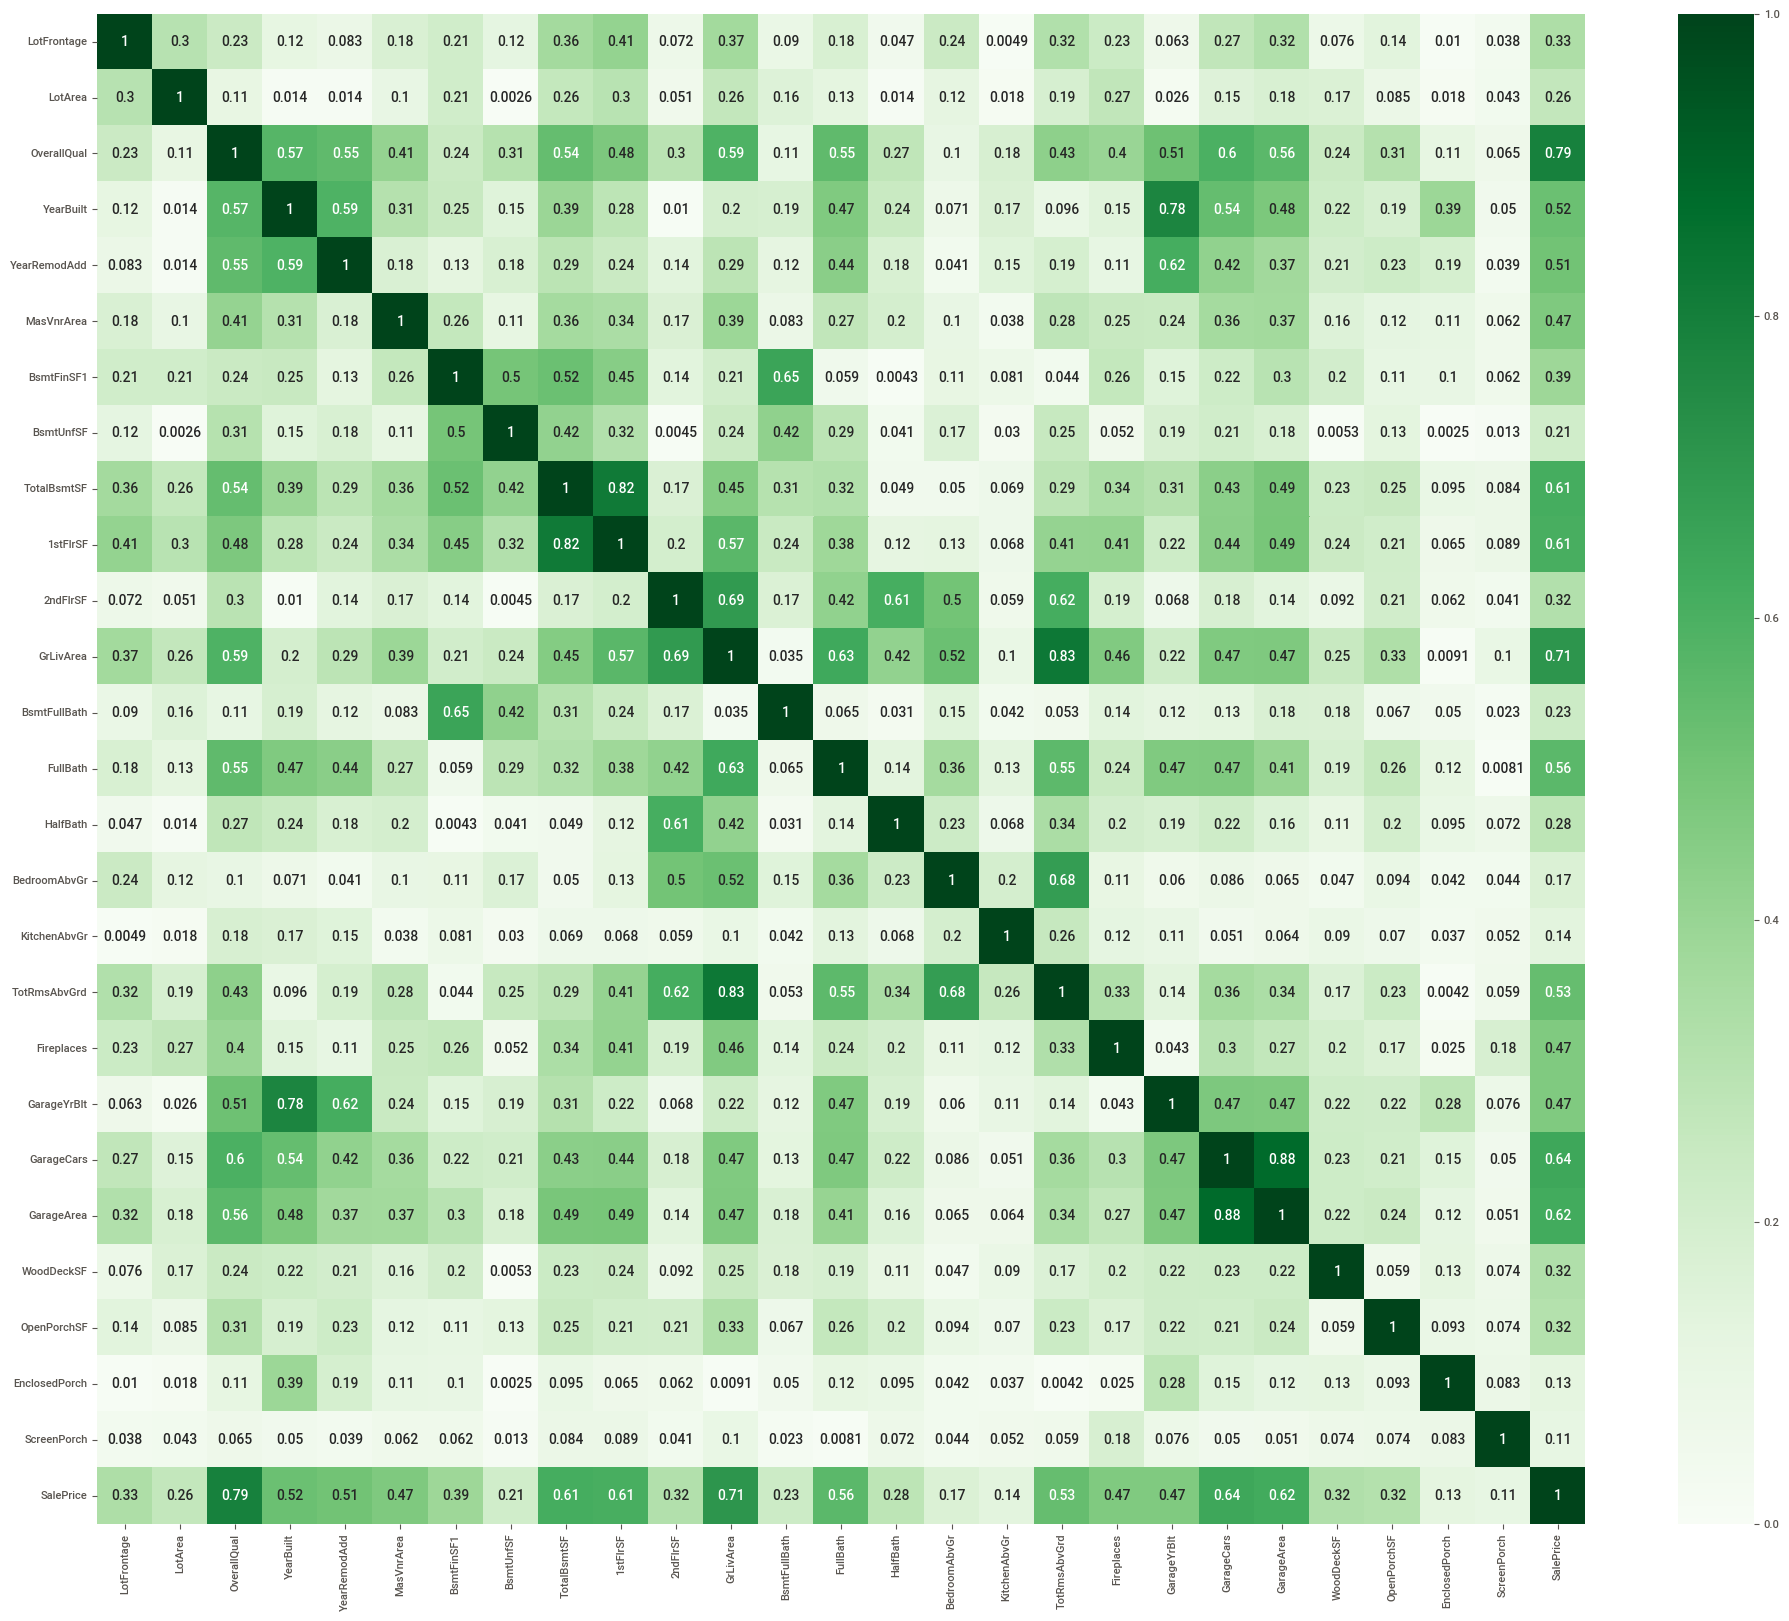

In [ ]:
# after encoding again remove any features that are not relevant
cor = abs(df_encoded.corr())
low_correlation_features=cor[cor['SalePrice'] < 0.1].index
df_encoded.drop(low_correlation_features, axis=1, inplace=True)

plt.figure(figsize=(24,20))
cor = abs(df.corr())
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens, vmin=0, vmax=1)
plt.show()

In [ ]:
df_encoded.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageQual_Fa,GarageCond_Fa,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,2003,2003,196.0,706,150,856,856,...,0,0,1,0,1,0,1,0,1,0
1,80.0,9600,6,1976,1976,0.0,978,284,1262,1262,...,0,0,1,0,1,0,1,0,1,0
2,68.0,11250,7,2001,2002,162.0,486,434,920,920,...,0,0,1,0,1,0,1,0,1,0
3,60.0,9550,7,1915,1970,0.0,216,540,756,961,...,0,0,1,0,1,0,1,1,0,0
4,84.0,14260,8,2000,2000,350.0,655,490,1145,1145,...,0,0,1,0,1,0,1,0,1,0


In [ ]:
# divide the data to features and target
t = df_encoded['SalePrice'].copy()
x = df_encoded.drop(['SalePrice'], axis=1)
print('t:')
display(t)
print()
print('X:')
display(x)

t:


0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64


X:


,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageQual_Fa,GarageCond_Fa,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,2003,2003,196.0,706,150,856,856,...,0,0,1,0,1,0,1,0,1,0
1,80.0,9600,6,1976,1976,0.0,978,284,1262,1262,...,0,0,1,0,1,0,1,0,1,0
2,68.0,11250,7,2001,2002,162.0,486,434,920,920,...,0,0,1,0,1,0,1,0,1,0
3,60.0,9550,7,1915,1970,0.0,216,540,756,961,...,0,0,1,0,1,0,1,1,0,0
4,84.0,14260,8,2000,2000,350.0,655,490,1145,1145,...,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,1999,2000,0.0,0,953,953,953,...,0,0,1,0,1,0,1,0,1,0
1456,85.0,13175,6,1978,1988,119.0,790,589,1542,2073,...,0,0,1,0,1,0,1,0,1,0
1457,66.0,9042,7,1941,2006,0.0,275,877,1152,1188,...,0,0,1,0,1,0,1,0,1,0
1458,68.0,9717,5,1950,1996,0.0,49,0,1078,1078,...,0,0,1,0,1,0,1,0,1,0


the values in the x columns are within different ranges so we would greatly benifit from normalizing the data.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

all_cols = np.array(x.columns)
ct = ColumnTransformer([("standard", MinMaxScaler(), all_cols)])

x_normalized = pd.DataFrame(ct.fit_transform(x, t), columns = all_cols)
display(x_normalized)

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageQual_Fa,GarageCond_Fa,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,0.150685,0.033420,0.666667,0.949275,0.883333,0.122500,0.125089,0.064212,0.140098,0.119780,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.202055,0.038795,0.555556,0.753623,0.433333,0.000000,0.173281,0.121575,0.206547,0.212942,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.160959,0.046507,0.666667,0.934783,0.866667,0.101250,0.086109,0.185788,0.150573,0.134465,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.133562,0.038561,0.666667,0.311594,0.333333,0.000000,0.038271,0.231164,0.123732,0.143873,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.215753,0.060576,0.777778,0.927536,0.833333,0.218750,0.116052,0.209760,0.187398,0.186095,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.140411,0.030929,0.555556,0.920290,0.833333,0.000000,0.000000,0.407962,0.155974,0.142038,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1456,0.219178,0.055505,0.555556,0.768116,0.633333,0.074375,0.139972,0.252140,0.252373,0.399036,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1457,0.154110,0.036187,0.666667,0.500000,0.933333,0.000000,0.048724,0.375428,0.188543,0.195961,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1458,0.160959,0.039342,0.444444,0.565217,0.766667,0.000000,0.008682,0.000000,0.176432,0.170721,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


**def functions for models**:

In [ ]:
import pandas as pd
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from tqdm.auto import tqdm
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
import plotly.express as px

# train and validate the model
def get_cv_score_and_loss(X, t, model, transformer=None, k=None, p=None, show_score_loss_graphs=False, use_pbar=True):
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])
    
    if k is not None:
        cv = model_selection.KFold(n_splits=k, shuffle=True, random_state=42)
        length = cv.n_splits
    elif p is not None:
        cv = model_selection.LeavePOut(p)
        length = cv.get_n_splits(X)
    else:
        raise ValueError('you need to specify k or p in order for the cv to work')

    if use_pbar:
        pbar = tqdm(desc='Computing Models', total=length)

    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        X_train = X.loc[train_ids] # Create train and val X and t
        t_train = t.loc[train_ids]
        X_val = X.loc[val_ids]
        t_val = t.loc[val_ids]
        

        model.fit(X_train, t_train) # Fitting on the model

        y_train = model.predict(X_train) # Getting predictions
        y_val = model.predict(X_val)
        
        
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train), np.sqrt(metrics.mean_squared_error(t_train, y_train))]
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'val', model.score(X_val, t_val), np.sqrt(metrics.mean_squared_error(t_val, y_val))]

        if use_pbar:
            pbar.update()

    if use_pbar:
        pbar.close()

    val_scores_losses_df = scores_losses_df[scores_losses_df['split']=='val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split']=='train']

    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    if show_score_loss_graphs:
        fig = px.line(scores_losses_df, x='fold_id', y='score', color='split', title=f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        fig.show()
        fig = px.line(scores_losses_df, x='fold_id', y='loss', color='split', title=f'Mean Val Loss: {mean_val_loss:.2f}, Mean Train Loss: {mean_train_loss:.2f}')
        fig.show()

    return mean_val_score, mean_val_loss, mean_train_score, mean_train_loss

In [ ]:
# run model and get results
def evaluate_model(X, model):
  val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X, t, model, k=5, show_score_loss_graphs=True)
  print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.2f}')
  print(f'mean cv train score: {train_score:.2f}\nmean cv train loss {train_loss:.2f}')

For this excise we will use Linear Regression and SGD Regressor, firstly we shall **Select Our Features**:

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

# select best features for LR model
selector_lr = RFECV(LinearRegression(), cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)).fit(x_normalized, t)
X_selected_features_lr = x_normalized.loc[:, selector_lr.support_]
display(X_selected_features_lr)

,LotFrontage,LotArea,OverallQual,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,BedroomAbvGr,...,BsmtQual_Fa,BsmtQual_TA,BsmtExposure_Gd,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Typ
0,0.150685,0.033420,0.666667,0.064212,0.140098,0.119780,0.413559,0.333333,0.666667,0.375,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.202055,0.038795,0.555556,0.121575,0.206547,0.212942,0.000000,0.000000,0.666667,0.375,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2,0.160959,0.046507,0.666667,0.185788,0.150573,0.134465,0.419370,0.333333,0.666667,0.375,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.133562,0.038561,0.666667,0.231164,0.123732,0.143873,0.366102,0.333333,0.333333,0.375,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.215753,0.060576,0.777778,0.209760,0.187398,0.186095,0.509927,0.333333,0.666667,0.500,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.140411,0.030929,0.555556,0.407962,0.155974,0.142038,0.336077,0.000000,0.666667,0.375,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1456,0.219178,0.055505,0.555556,0.252140,0.252373,0.399036,0.000000,0.333333,0.666667,0.375,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1457,0.154110,0.036187,0.666667,0.375428,0.188543,0.195961,0.557869,0.000000,0.666667,0.500,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1458,0.160959,0.039342,0.444444,0.000000,0.176432,0.170721,0.000000,0.333333,0.333333,0.250,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
# select best features for SGD model
selector_sgd = RFECV(SGDRegressor(max_iter = 10000), cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)).fit(x_normalized, t)
X_selected_features_sgd = x_normalized.loc[:, selector_sgd.support_]
display(X_selected_features_sgd)

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageFinish_Unf,GarageQual_Fa,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,0.033420,0.666667,0.949275,0.883333,0.122500,0.125089,0.064212,0.140098,0.119780,0.413559,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.038795,0.555556,0.753623,0.433333,0.000000,0.173281,0.121575,0.206547,0.212942,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.046507,0.666667,0.934783,0.866667,0.101250,0.086109,0.185788,0.150573,0.134465,0.419370,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.038561,0.666667,0.311594,0.333333,0.000000,0.038271,0.231164,0.123732,0.143873,0.366102,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.060576,0.777778,0.927536,0.833333,0.218750,0.116052,0.209760,0.187398,0.186095,0.509927,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.030929,0.555556,0.920290,0.833333,0.000000,0.000000,0.407962,0.155974,0.142038,0.336077,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1456,0.055505,0.555556,0.768116,0.633333,0.074375,0.139972,0.252140,0.252373,0.399036,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1457,0.036187,0.666667,0.500000,0.933333,0.000000,0.048724,0.375428,0.188543,0.195961,0.557869,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1458,0.039342,0.444444,0.565217,0.766667,0.000000,0.008682,0.000000,0.176432,0.170721,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


The LR model settled down on 40 features and the sgd model on 72 features.

Now that we have the best features for the models we can create the best version of each type and compare:

In [ ]:
# evaluate the LR model
print('LinearRegression')
evaluate_model(X_selected_features_lr, selector_lr)

LinearRegression


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

mean cv val score: 0.81
mean cv val loss 32994.14
mean cv train score: 0.87
mean cv train loss 28944.27


In [ ]:
# evaluate the SGD model
print('SGDRegressor')
evaluate_model(X_selected_features_sgd, selector_sgd)

SGDRegressor


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

mean cv val score: 0.82
mean cv val loss 32307.32
mean cv train score: 0.88
mean cv train loss 27953.16


A cross the board we get better resuslts on the SGD Regressor, higher Score and a lower Loss, so we will continue with that model.



In [ ]:
# save the best featurse of the choosen model
best_cols = X_selected_features_sgd.columns

The next step is to find out the best values for the model hyper parameters, for that we will preform a two types of  searches, GridSearchCV and RandomizedSearchCV:

In [ ]:
# find hyper parameers with grid search
from sklearn.model_selection import GridSearchCV

hyper_parameters = {'penalty': ('l2', 'l1', 'elasticnet'), 'alpha': [0.0001, 0.001, 0.01, 0.1], 'eta0': [0.001, 0.01, 0.1, 0.5]}
gs_model = GridSearchCV(SGDRegressor(random_state=42, max_iter = 10000), hyper_parameters).fit(X_selected_features_sgd, t)
print('best params', gs_model.best_params_)

best params {'alpha': 0.0001, 'eta0': 0.001, 'penalty': 'l1'}


In [ ]:
# find hyper parameers with random search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

np.random.seed(42)
distributions = dict(alpha=uniform(loc=0, scale=1), penalty=['l2', 'l1', 'elasticnet'], eta0=[0.001, 0.01, 0.1, 0.5])
rs_model = RandomizedSearchCV(SGDRegressor(random_state=42, max_iter = 100000), distributions, random_state=42).fit(X_selected_features_sgd, t)
print('best params', rs_model.best_params_)

best params {'alpha': 0.020584494295802447, 'eta0': 0.01, 'penalty': 'l1'}


In [ ]:
print('GridSearchCV')
evaluate_model(X_selected_features_sgd, gs_model)

GridSearchCV


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

mean cv val score: 0.82
mean cv val loss 32619.58
mean cv train score: 0.88
mean cv train loss 27707.26


In [ ]:
print('RandomizedSearchCV')
evaluate_model(X_selected_features_sgd, rs_model)

RandomizedSearchCV


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

mean cv val score: 0.82
mean cv val loss 32651.03
mean cv train score: 0.88
mean cv train loss 27731.33


Even after trying to optimize the model with changing the values of hyper parameters we got the same mean cv validation, so we'll just use the defalut values we have been using.

**Test:**

In [ ]:
# procces the test df for run
test = pd.read_csv("/content/drive/MyDrive/CS - Courses/ML/EX2/test.csv")
test.drop(columns_to_drop, axis=1, inplace=True)
objects_names, numerical_names = split_types(test)
fill_cols_median_val(test, numerical_names)
fill_cols_mode_val(test, objects_names)
test_empty_columns = count_empty_values_in_cols(test)
test_encoded = encode_categorical(test, objects_names)
all_cols = np.array(test_encoded.columns)
ct = ColumnTransformer([("standard", MinMaxScaler(), all_cols)])
test_normilized = pd.DataFrame(ct.fit_transform(test_encoded), columns=all_cols)
best_x_test = test_normilized[best_cols] 
best_x_test

empty values
------------



,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageFinish_Unf,GarageQual_Fa,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,0.184147,0.444444,0.625954,0.183333,0.000000,0.116708,0.126168,0.173111,0.104309,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.232124,0.555556,0.603053,0.133333,0.083721,0.230175,0.189720,0.260844,0.196672,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.224197,0.444444,0.900763,0.800000,0.000000,0.197257,0.064019,0.182139,0.111135,0.376477,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.154326,0.555556,0.908397,0.800000,0.015504,0.150125,0.151402,0.181747,0.110708,0.364125,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.064121,0.777778,0.862595,0.700000,0.000000,0.065586,0.475234,0.251227,0.186220,0.000000,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.008453,0.333333,0.694656,0.333333,0.000000,0.000000,0.255140,0.107164,0.029650,0.293233,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1455,0.007691,0.333333,0.694656,0.333333,0.000000,0.062843,0.137383,0.107164,0.029650,0.293233,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1456,0.336115,0.444444,0.618321,0.766667,0.000000,0.305237,0.000000,0.240236,0.174275,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1457,0.162724,0.444444,0.862595,0.700000,0.000000,0.084040,0.268692,0.178999,0.120094,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# build final model
model = RFECV(SGDRegressor(), cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)).fit(X_selected_features_sgd, t)

In [ ]:
# create results for test csv
res = pd.read_csv("/content/drive/MyDrive/CS - Courses/ML/EX2/sample_submission.csv")
res['SalePrice'] = model.predict(best_x_test)
res.to_csv('KF_Results.csv', index=False)
display(res)

,Id,SalePrice
0,1461,101373.908733
1,1462,149700.552246
2,1463,172579.228091
3,1464,186562.337745
4,1465,205945.114231
...,...,...
1454,2915,63669.223211
1455,2916,74016.235332
1456,2917,161965.874649
1457,2918,124261.145220


**Conclusion:**

In this excise we had to deal with a huge amount of features, even after editing the data and removing irrelevant features we still had a substantial amount of features.

to deal with that we used feature selection strategies to get the best combinations of feature to train our models apon, so we trained two models LR and SGD and saw thier CV on each group of best features respectively, then continued our work with the best preforming one - SGD.

Our next step was to find the best values for the hyper parameters of the model, we search using two different techniques random search and grind search then ploted their best version of the model which we found out had no real improvments, so we stuck to the default version.

In the last step we created the model accordingly and run the test data on it, finally we created a csv fill to submit the results.

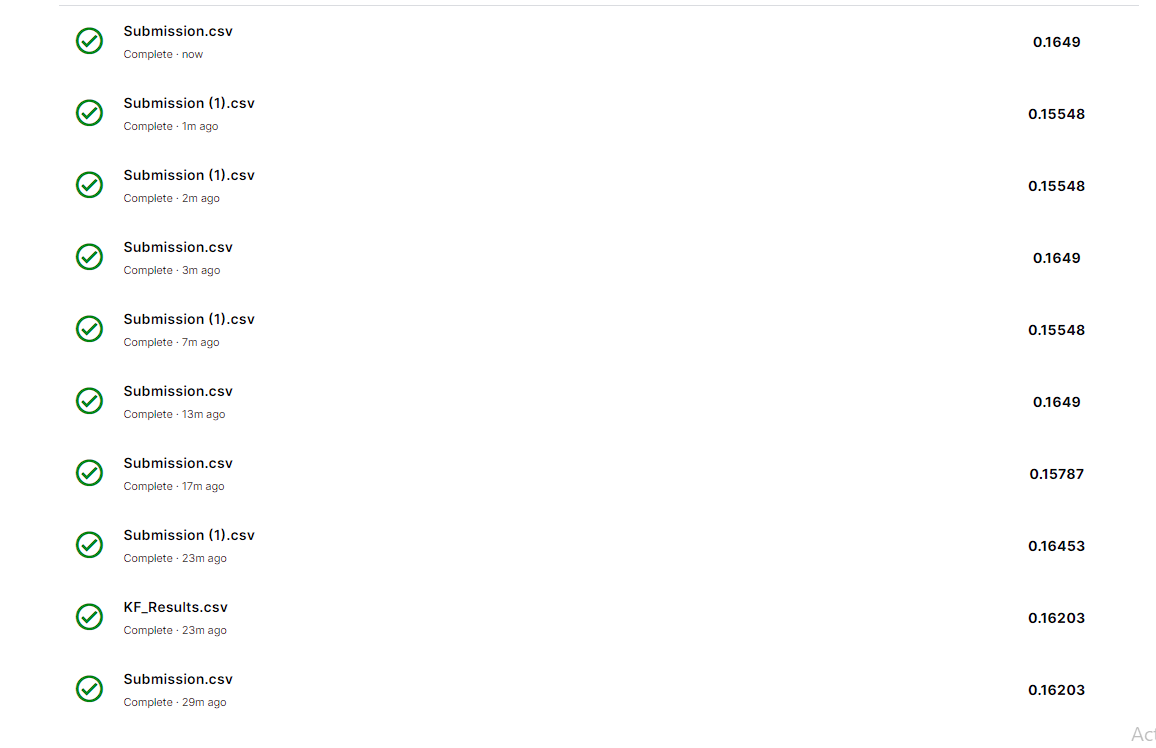

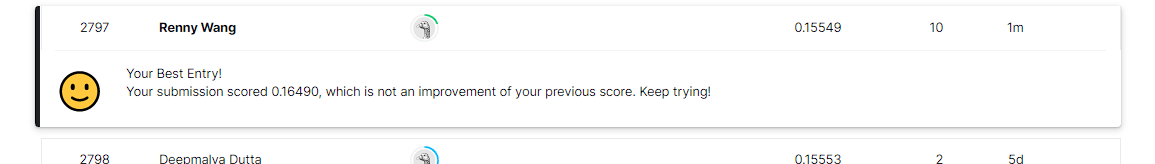

In [ ]:
Refrences:

https://www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation
https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection
https://www.kaggle.com/code/maheshnanavare/housing-prices2-xgboost-gridsearch
https://www.youtube.com/watch?v=S7B4MbBmfSk&ab_channel=PradheepSenthamarai
https://www.youtube.com/watch?v=vtm35gVP8JU&ab_channel=KrishNaik

In [ ]:
%%shell
jupyter nbconvert --to html /ML_ex2_house_prices.ipynb

[NbConvertApp] Converting notebook /ML_ex2_house_prices.ipynb to html
[NbConvertApp] Writing 8203908 bytes to /ML_ex2_house_prices.html


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
